# Testy Stacjonarności - WESAD Dataset

Ten notebook przeprowadza testy stacjonarności na sygnałach z bazy WESAD:

1. **Augmented Dickey-Fuller (ADF) Test**
   - H₀: Szereg ma unit root (nie jest stacjonarny)
   - H₁: Szereg jest stacjonarny
   - Jeśli p-value < 0.05, odrzucamy H₀ → szereg jest stacjonarny

2. **Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test**
   - H₀: Szereg jest stacjonarny
   - H₁: Szereg ma unit root (nie jest stacjonarny)
   - Jeśli p-value < 0.05, odrzucamy H₀ → szereg nie jest stacjonarny

## Interpretacja wyników:

- **ADF p-value < 0.05** i **KPSS p-value > 0.05** → szereg jest **stacjonarny** ✅
- **ADF p-value > 0.05** i **KPSS p-value < 0.05** → szereg **nie jest stacjonarny** ❌
- Jeśli wyniki są sprzeczne, potrzebna jest dodatkowa analiza

## Sygnały testowane:
- ACC (accelerometer) - x, y, z
- BVP (blood volume pulse)
- EDA (electrodermal activity)
- TEMP (temperature)


## KROK 1: Import bibliotek


In [10]:
# ============================================================================
# KROK 1: IMPORT BIBLIOTEK
# ============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle
import warnings
warnings.filterwarnings('ignore')

# Testy stacjonarności
from statsmodels.tsa.stattools import adfuller, kpss

# Konfiguracja wykresów
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ Wszystkie biblioteki zaimportowane pomyślnie")


✅ Wszystkie biblioteki zaimportowane pomyślnie


## KROK 2: Wczytywanie danych WESAD


In [11]:
# ============================================================================
# KROK 2: WCZYTYWANIE DANYCH WESAD
# ============================================================================

# Ścieżki
RAW_ROOT = Path("/Users/turfian/Downloads/archive (4)/WESAD")
DEFAULT_SUBJECTS = ["S2", "S3", "S4", "S5", "S6", "S7"]

def load_wesad_pickle(subject: str, raw_root: Path = RAW_ROOT) -> dict:
    """Wczytuje dane z pliku PKL"""
    pkl_path = raw_root / subject / f"{subject}.pkl"
    if not pkl_path.exists():
        raise FileNotFoundError(f"Brak pliku {pkl_path}")
    with pkl_path.open("rb") as handle:
        return pickle.load(handle, encoding="latin1")

print("=" * 80)
print("KROK 2: WCZYTYWANIE DANYCH")
print("=" * 80)

# Wczytaj dane dla wszystkich subjectów
all_signals = {}

for subject in DEFAULT_SUBJECTS:
    print(f"\n📂 Wczytuję dane dla {subject}...")
    try:
        data = load_wesad_pickle(subject)
        
        # DIAGNOSTYKA: Sprawdź strukturę danych
        if 'signal' not in data:
            print(f"  ⚠️ Brak klucza 'signal' w danych")
            continue
        
        # Wyciągnij sygnały z nadgarstka
        wrist_signals = data['signal'].get('wrist', {})
        
        if not wrist_signals:
            print(f"  ⚠️ Brak sygnałów z nadgarstka")
            continue
        
        print(f"  🔍 Dostępne sygnały: {list(wrist_signals.keys())}")
        
        if subject not in all_signals:
            all_signals[subject] = {}
        
        # ACC (3 osie: x, y, z)
        if 'ACC' in wrist_signals:
            acc_data = wrist_signals['ACC']
            print(f"    ACC type: {type(acc_data)}, shape: {np.array(acc_data).shape if hasattr(acc_data, '__len__') else 'N/A'}")
            
            # Konwertuj na numpy array
            if isinstance(acc_data, np.ndarray):
                acc_array = acc_data
            elif isinstance(acc_data, list):
                acc_array = np.array(acc_data[0]) if len(acc_data) > 0 and isinstance(acc_data[0], np.ndarray) else np.array(acc_data)
            else:
                acc_array = np.array(acc_data)
            
            # Obsłuż różne kształty
            if acc_array.ndim == 2 and acc_array.shape[1] >= 3:
                all_signals[subject]['acc_x'] = acc_array[:, 0]
                all_signals[subject]['acc_y'] = acc_array[:, 1]
                all_signals[subject]['acc_z'] = acc_array[:, 2]
                print(f"    ✅ ACC: x={len(all_signals[subject]['acc_x'])}, y={len(all_signals[subject]['acc_y'])}, z={len(all_signals[subject]['acc_z'])}")
            elif acc_array.ndim == 1:
                all_signals[subject]['acc'] = acc_array
                print(f"    ✅ ACC: {len(acc_array)} próbek")
        
        # BVP
        if 'BVP' in wrist_signals:
            bvp_data = wrist_signals['BVP']
            print(f"    BVP type: {type(bvp_data)}")
            
            if isinstance(bvp_data, np.ndarray):
                bvp_array = bvp_data
            elif isinstance(bvp_data, list):
                bvp_array = np.array(bvp_data[0]) if len(bvp_data) > 0 and isinstance(bvp_data[0], np.ndarray) else np.array(bvp_data)
            else:
                bvp_array = np.array(bvp_data)
            
            all_signals[subject]['bvp'] = bvp_array.flatten()
            print(f"    ✅ BVP: {len(all_signals[subject]['bvp'])} próbek")
        
        # EDA
        if 'EDA' in wrist_signals:
            eda_data = wrist_signals['EDA']
            print(f"    EDA type: {type(eda_data)}")
            
            if isinstance(eda_data, np.ndarray):
                eda_array = eda_data
            elif isinstance(eda_data, list):
                eda_array = np.array(eda_data[0]) if len(eda_data) > 0 and isinstance(eda_data[0], np.ndarray) else np.array(eda_data)
            else:
                eda_array = np.array(eda_data)
            
            all_signals[subject]['eda'] = eda_array.flatten()
            print(f"    ✅ EDA: {len(all_signals[subject]['eda'])} próbek")
        
        # TEMP
        if 'TEMP' in wrist_signals:
            temp_data = wrist_signals['TEMP']
            print(f"    TEMP type: {type(temp_data)}")
            
            if isinstance(temp_data, np.ndarray):
                temp_array = temp_data
            elif isinstance(temp_data, list):
                temp_array = np.array(temp_data[0]) if len(temp_data) > 0 and isinstance(temp_data[0], np.ndarray) else np.array(temp_data)
            else:
                temp_array = np.array(temp_data)
            
            all_signals[subject]['temp'] = temp_array.flatten()
            print(f"    ✅ TEMP: {len(all_signals[subject]['temp'])} próbek")
        
        print(f"  ✅ Wczytano sygnały dla {subject}")
        
    except Exception as e:
        print(f"  ❌ Błąd podczas wczytywania {subject}: {e}")
        import traceback
        traceback.print_exc()
        continue

print(f"\n{'='*80}")
print("PODSUMOWANIE WCZYTYWANIA")
print(f"{'='*80}")
print(f"✅ Wczytano dane dla {len(all_signals)} subjectów")

# Wyświetl dostępne sygnały
for subject, signals in all_signals.items():
    print(f"\n  {subject}:")
    for signal_name, signal_data in signals.items():
        if signal_data is not None:
            print(f"    - {signal_name}: {len(signal_data)} próbek")


KROK 2: WCZYTYWANIE DANYCH

📂 Wczytuję dane dla S2...
  🔍 Dostępne sygnały: ['ACC', 'BVP', 'EDA', 'TEMP']
    ACC type: <class 'numpy.ndarray'>, shape: (194528, 3)
    ✅ ACC: x=194528, y=194528, z=194528
    BVP type: <class 'numpy.ndarray'>
    ✅ BVP: 389056 próbek
    EDA type: <class 'numpy.ndarray'>
    ✅ EDA: 24316 próbek
    TEMP type: <class 'numpy.ndarray'>
    ✅ TEMP: 24316 próbek
  ✅ Wczytano sygnały dla S2

📂 Wczytuję dane dla S3...
  🔍 Dostępne sygnały: ['ACC', 'BVP', 'EDA', 'TEMP']
    ACC type: <class 'numpy.ndarray'>, shape: (207776, 3)
    ✅ ACC: x=207776, y=207776, z=207776
    BVP type: <class 'numpy.ndarray'>
    ✅ BVP: 415552 próbek
    EDA type: <class 'numpy.ndarray'>
    ✅ EDA: 25972 próbek
    TEMP type: <class 'numpy.ndarray'>
    ✅ TEMP: 25972 próbek
  ✅ Wczytano sygnały dla S3

📂 Wczytuję dane dla S4...
  🔍 Dostępne sygnały: ['ACC', 'BVP', 'EDA', 'TEMP']
    ACC type: <class 'numpy.ndarray'>, shape: (205536, 3)
    ✅ ACC: x=205536, y=205536, z=205536
    BVP 

## KROK 3: Funkcje do testów stacjonarności


In [12]:
# ============================================================================
# KROK 3: FUNKCJE DO TESTÓW STACJONARNOŚCI
# ============================================================================

def perform_adf_test(series, signal_name="", maxlag=None):
    """
    Przeprowadza test Augmented Dickey-Fuller (ADF)
    
    H₀: Szereg ma unit root (nie jest stacjonarny)
    H₁: Szereg jest stacjonarny
    
    Returns:
        dict: Wyniki testu (statistic, pvalue, is_stationary)
    """
    # Usuń NaN i nieskończone wartości
    series_clean = series.dropna() if isinstance(series, pd.Series) else series[~np.isnan(series) & ~np.isinf(series)]
    
    if len(series_clean) < 10:
        return {
            'statistic': np.nan,
            'pvalue': np.nan,
            'is_stationary': False,
            'error': 'Za mało danych'
        }
    
    try:
        result = adfuller(series_clean, maxlag=maxlag, autolag='AIC')
        
        adf_statistic = result[0]
        pvalue = result[1]
        critical_values = result[4]
        
        # Szereg jest stacjonarny jeśli p-value < 0.05
        is_stationary = pvalue < 0.05
        
        return {
            'statistic': adf_statistic,
            'pvalue': pvalue,
            'critical_values': critical_values,
            'is_stationary': is_stationary,
            'error': None
        }
    except Exception as e:
        return {
            'statistic': np.nan,
            'pvalue': np.nan,
            'is_stationary': False,
            'error': str(e)
        }

def perform_kpss_test(series, signal_name="", regression='c'):
    """
    Przeprowadza test Kwiatkowski-Phillips-Schmidt-Shin (KPSS)
    
    H₀: Szereg jest stacjonarny
    H₁: Szereg ma unit root (nie jest stacjonarny)
    
    Parameters:
        regression: 'c' (constant) lub 'ct' (constant + trend)
    
    Returns:
        dict: Wyniki testu (statistic, pvalue, is_stationary)
    """
    # Usuń NaN i nieskończone wartości
    series_clean = series.dropna() if isinstance(series, pd.Series) else series[~np.isnan(series) & ~np.isinf(series)]
    
    if len(series_clean) < 10:
        return {
            'statistic': np.nan,
            'pvalue': np.nan,
            'is_stationary': False,
            'error': 'Za mało danych'
        }
    
    try:
        result = kpss(series_clean, regression=regression, nlags='auto')
        
        kpss_statistic = result[0]
        pvalue = result[1]
        critical_values = result[3]
        
        # Szereg jest stacjonarny jeśli p-value > 0.05 (nie odrzucamy H₀)
        is_stationary = pvalue > 0.05
        
        return {
            'statistic': kpss_statistic,
            'pvalue': pvalue,
            'critical_values': critical_values,
            'is_stationary': is_stationary,
            'error': None
        }
    except Exception as e:
        return {
            'statistic': np.nan,
            'pvalue': np.nan,
            'is_stationary': False,
            'error': str(e)
        }

print("✅ Funkcje do testów stacjonarności zdefiniowane")


✅ Funkcje do testów stacjonarności zdefiniowane


## KROK 4: Przeprowadzenie testów stacjonarności


In [14]:
# ============================================================================
# KROK 4: PRZEPROWADZENIE TESTÓW STACJONARNOŚCI
# ============================================================================

print("=" * 80)
print("KROK 4: PRZEPROWADZENIE TESTÓW STACJONARNOŚCI")
print("=" * 80)

# Sprawdź czy dane są wczytane
if 'all_signals' not in globals() or not all_signals:
    print("\n❌❌❌ BŁĄD: Brak danych do analizy!")
    print("   Najpierw uruchom KROK 2 (WCZYTYWANIE DANYCH)")
    print("   Upewnij się, że all_signals zawiera dane")
    results_df = pd.DataFrame()  # Pusty DataFrame
else:
    # Przechowuj wyniki
    results = []

    # Limit długości sygnału (aby przyspieszyć obliczenia)
    MAX_SAMPLES = 10000  # Maksymalna liczba próbek do analizy

    for subject, signals in all_signals.items():
        print(f"\n📊 Analizuję {subject}...")
        
        for signal_name, signal_data in signals.items():
            if signal_data is None or len(signal_data) == 0:
                continue
            
            # Ogranicz długość sygnału
            signal_limited = signal_data[:MAX_SAMPLES] if len(signal_data) > MAX_SAMPLES else signal_data
            
            # Konwertuj na pandas Series
            if not isinstance(signal_limited, pd.Series):
                signal_series = pd.Series(signal_limited)
            else:
                signal_series = signal_limited
            
            print(f"  🔍 Testuję {signal_name} ({len(signal_series)} próbek)...")
            
            # Test ADF
            adf_result = perform_adf_test(signal_series, signal_name)
            
            # Test KPSS
            kpss_result = perform_kpss_test(signal_series, signal_name)
            
            # Określ czy szereg jest stacjonarny (oba testy muszą się zgadzać)
            if adf_result['error'] is None and kpss_result['error'] is None:
                # Szereg jest stacjonarny jeśli:
                # - ADF: p-value < 0.05 (odrzucamy H₀: nie jest stacjonarny) → jest stacjonarny
                # - KPSS: p-value > 0.05 (nie odrzucamy H₀: jest stacjonarny) → jest stacjonarny
                is_stationary = adf_result['is_stationary'] and kpss_result['is_stationary']
                
                # Jeśli wyniki są sprzeczne, oznacz jako "niepewny"
                if adf_result['is_stationary'] != kpss_result['is_stationary']:
                    is_stationary = None  # Niepewny
            else:
                is_stationary = None
            
            # Zapisz wyniki
            results.append({
                'subject': subject,
                'signal': signal_name,
                'n_samples': len(signal_series),
                'adf_statistic': adf_result['statistic'],
                'adf_pvalue': adf_result['pvalue'],
                'adf_stationary': adf_result['is_stationary'],
                'kpss_statistic': kpss_result['statistic'],
                'kpss_pvalue': kpss_result['pvalue'],
                'kpss_stationary': kpss_result['is_stationary'],
                'is_stationary': is_stationary,
                'adf_error': adf_result['error'],
                'kpss_error': kpss_result['error']
            })

    # Stwórz DataFrame z wynikami
    results_df = pd.DataFrame(results)

    print(f"\n{'='*80}")
    print("PODSUMOWANIE TESTÓW")
    print(f"{'='*80}")
    print(f"✅ Przeprowadzono {len(results)} testów")

    # Wyświetl wyniki
    if len(results_df) > 0:
        print("\n📊 WYNIKI TESTÓW:")
        print(results_df.to_string(index=False))
    else:
        print("\n⚠️ Brak wyników - sprawdź czy dane zostały poprawnie wczytane")


KROK 4: PRZEPROWADZENIE TESTÓW STACJONARNOŚCI

📊 Analizuję S2...
  🔍 Testuję acc_x (10000 próbek)...
  🔍 Testuję acc_y (10000 próbek)...
  🔍 Testuję acc_z (10000 próbek)...
  🔍 Testuję bvp (10000 próbek)...
  🔍 Testuję eda (10000 próbek)...
  🔍 Testuję temp (10000 próbek)...

📊 Analizuję S3...
  🔍 Testuję acc_x (10000 próbek)...
  🔍 Testuję acc_y (10000 próbek)...
  🔍 Testuję acc_z (10000 próbek)...
  🔍 Testuję bvp (10000 próbek)...
  🔍 Testuję eda (10000 próbek)...
  🔍 Testuję temp (10000 próbek)...

📊 Analizuję S4...
  🔍 Testuję acc_x (10000 próbek)...
  🔍 Testuję acc_y (10000 próbek)...
  🔍 Testuję acc_z (10000 próbek)...
  🔍 Testuję bvp (10000 próbek)...
  🔍 Testuję eda (10000 próbek)...
  🔍 Testuję temp (10000 próbek)...

📊 Analizuję S5...
  🔍 Testuję acc_x (10000 próbek)...
  🔍 Testuję acc_y (10000 próbek)...
  🔍 Testuję acc_z (10000 próbek)...
  🔍 Testuję bvp (10000 próbek)...
  🔍 Testuję eda (10000 próbek)...
  🔍 Testuję temp (10000 próbek)...

📊 Analizuję S6...
  🔍 Testuję acc

## KROK 5: Wizualizacja wyników


KROK 5: WIZUALIZACJA WYNIKÓW

📊 TABELA WYNIKÓW:
subject signal   adf_pvalue  kpss_pvalue  adf_stationary  kpss_stationary is_stationary
     S2  acc_x 3.677211e-08         0.01            True            False          None
     S2  acc_y 3.311254e-04         0.01            True            False          None
     S2  acc_z 2.876733e-05         0.01            True            False          None
     S2    bvp 0.000000e+00         0.10            True             True          True
     S2    eda 3.785542e-01         0.01           False            False         False
     S2   temp 1.000000e+00         0.01           False            False         False
     S3  acc_x 1.149908e-07         0.01            True            False          None
     S3  acc_y 4.759715e-03         0.01            True            False          None
     S3  acc_z 1.508293e-02         0.01            True            False          None
     S3    bvp 0.000000e+00         0.10            True             Tru

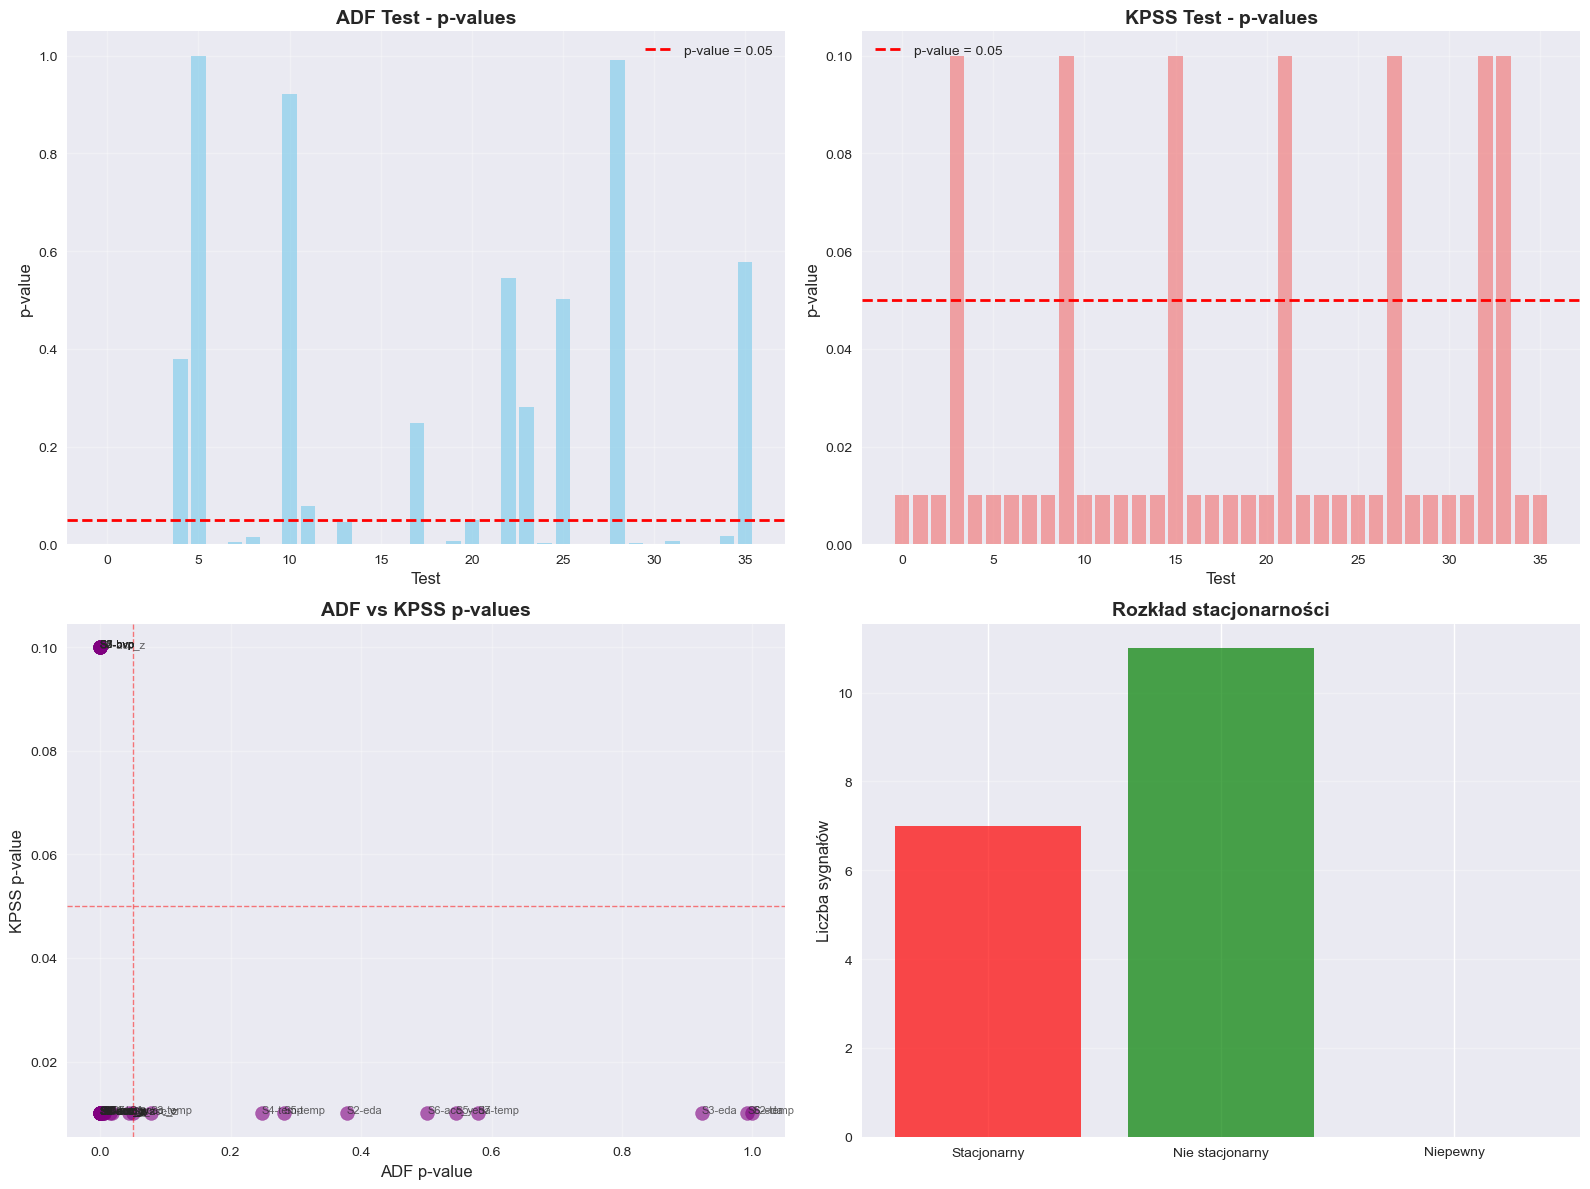

✅ Wizualizacje wygenerowane


In [15]:
# ============================================================================
# KROK 5: WIZUALIZACJA WYNIKÓW
# ============================================================================

print("=" * 80)
print("KROK 5: WIZUALIZACJA WYNIKÓW")
print("=" * 80)

# 1. Tabela z wynikami
print("\n📊 TABELA WYNIKÓW:")
display_cols = ['subject', 'signal', 'adf_pvalue', 'kpss_pvalue', 'adf_stationary', 'kpss_stationary', 'is_stationary']
print(results_df[display_cols].to_string(index=False))

# 2. Wykres p-values
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# ADF p-values
ax1 = axes[0, 0]
adf_pvalues = results_df['adf_pvalue'].dropna()
ax1.bar(range(len(adf_pvalues)), adf_pvalues, alpha=0.7, color='skyblue')
ax1.axhline(y=0.05, color='r', linestyle='--', linewidth=2, label='p-value = 0.05')
ax1.set_xlabel('Test', fontsize=12)
ax1.set_ylabel('p-value', fontsize=12)
ax1.set_title('ADF Test - p-values', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# KPSS p-values
ax2 = axes[0, 1]
kpss_pvalues = results_df['kpss_pvalue'].dropna()
ax2.bar(range(len(kpss_pvalues)), kpss_pvalues, alpha=0.7, color='lightcoral')
ax2.axhline(y=0.05, color='r', linestyle='--', linewidth=2, label='p-value = 0.05')
ax2.set_xlabel('Test', fontsize=12)
ax2.set_ylabel('p-value', fontsize=12)
ax2.set_title('KPSS Test - p-values', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Porównanie ADF vs KPSS (p-values)
ax3 = axes[1, 0]
valid_results = results_df.dropna(subset=['adf_pvalue', 'kpss_pvalue'])
if len(valid_results) > 0:
    ax3.scatter(valid_results['adf_pvalue'], valid_results['kpss_pvalue'], 
               alpha=0.6, s=100, c='purple')
    ax3.axvline(x=0.05, color='r', linestyle='--', linewidth=1, alpha=0.5)
    ax3.axhline(y=0.05, color='r', linestyle='--', linewidth=1, alpha=0.5)
    ax3.set_xlabel('ADF p-value', fontsize=12)
    ax3.set_ylabel('KPSS p-value', fontsize=12)
    ax3.set_title('ADF vs KPSS p-values', fontsize=14, fontweight='bold')
    ax3.grid(True, alpha=0.3)
    
    # Dodaj etykiety
    for idx, row in valid_results.iterrows():
        ax3.annotate(f"{row['subject']}-{row['signal']}", 
                    (row['adf_pvalue'], row['kpss_pvalue']),
                    fontsize=8, alpha=0.7)

# Rozkład stacjonarności
ax4 = axes[1, 1]
stationary_counts = results_df['is_stationary'].value_counts()
colors = ['green' if x == True else 'red' if x == False else 'gray' for x in stationary_counts.index]
ax4.bar(['Stacjonarny', 'Nie stacjonarny', 'Niepewny'], 
        [stationary_counts.get(True, 0), stationary_counts.get(False, 0), stationary_counts.get(None, 0)],
        color=colors, alpha=0.7)
ax4.set_ylabel('Liczba sygnałów', fontsize=12)
ax4.set_title('Rozkład stacjonarności', fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("✅ Wizualizacje wygenerowane")


## KROK 6: Szczegółowa analiza per sygnał


KROK 6: SZCZEGÓŁOWA ANALIZA PER SYGNAŁ

📊 PODSUMOWANIE PER SYGNAŁ:
        Średnie ADF p-value  Średnie KPSS p-value  Liczba stacjonarnych  Średnia liczba próbek
signal                                                                                        
acc_x                0.0005                 0.010                     0                10000.0
acc_y                0.0939                 0.010                     0                10000.0
acc_z                0.0109                 0.025                     1                10000.0
bvp                  0.0000                 0.100                     6                10000.0
eda                  0.4760                 0.010                     0                10000.0
temp                 0.3648                 0.010                     0                10000.0


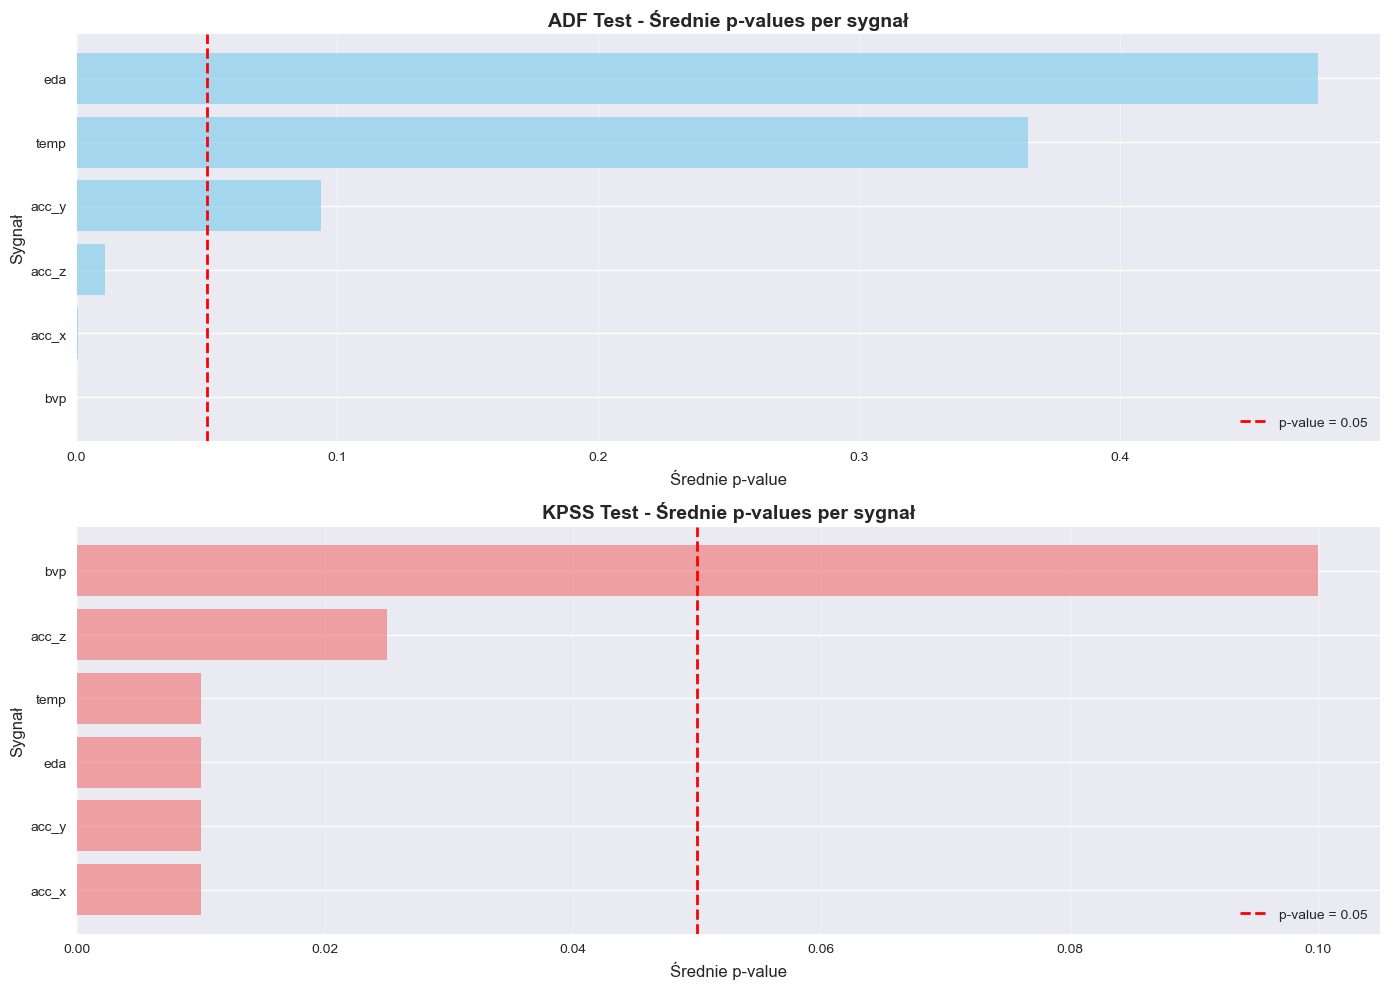

✅ Analiza per sygnał zakończona


In [16]:
# ============================================================================
# KROK 6: SZCZEGÓŁOWA ANALIZA PER SYGNAŁ
# ============================================================================

print("=" * 80)
print("KROK 6: SZCZEGÓŁOWA ANALIZA PER SYGNAŁ")
print("=" * 80)

# Grupuj wyniki per sygnał
signal_summary = results_df.groupby('signal').agg({
    'adf_pvalue': 'mean',
    'kpss_pvalue': 'mean',
    'is_stationary': lambda x: (x == True).sum(),  # Liczba stacjonarnych
    'n_samples': 'mean'
}).round(4)

signal_summary.columns = ['Średnie ADF p-value', 'Średnie KPSS p-value', 'Liczba stacjonarnych', 'Średnia liczba próbek']

print("\n📊 PODSUMOWANIE PER SYGNAŁ:")
print(signal_summary.to_string())

# Wykres porównawczy per sygnał
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# ADF p-values per sygnał
ax1 = axes[0]
signal_adf = results_df.groupby('signal')['adf_pvalue'].mean().sort_values()
ax1.barh(signal_adf.index, signal_adf.values, alpha=0.7, color='skyblue')
ax1.axvline(x=0.05, color='r', linestyle='--', linewidth=2, label='p-value = 0.05')
ax1.set_xlabel('Średnie p-value', fontsize=12)
ax1.set_ylabel('Sygnał', fontsize=12)
ax1.set_title('ADF Test - Średnie p-values per sygnał', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3, axis='x')

# KPSS p-values per sygnał
ax2 = axes[1]
signal_kpss = results_df.groupby('signal')['kpss_pvalue'].mean().sort_values()
ax2.barh(signal_kpss.index, signal_kpss.values, alpha=0.7, color='lightcoral')
ax2.axvline(x=0.05, color='r', linestyle='--', linewidth=2, label='p-value = 0.05')
ax2.set_xlabel('Średnie p-value', fontsize=12)
ax2.set_ylabel('Sygnał', fontsize=12)
ax2.set_title('KPSS Test - Średnie p-values per sygnał', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print("✅ Analiza per sygnał zakończona")


## KROK 7: Wnioski i interpretacja


In [17]:
# ============================================================================
# KROK 7: WNIOSKI I INTERPRETACJA
# ============================================================================

print("=" * 80)
print("KROK 7: WNIOSKI I INTERPRETACJA")
print("=" * 80)

# Statystyki ogólne
total_tests = len(results_df)

if total_tests == 0:
    print(f"\n❌ BŁĄD: Nie przeprowadzono żadnych testów!")
    print(f"   Sprawdź czy dane zostały poprawnie wczytane w KROK 2")
    print(f"   Upewnij się, że all_signals zawiera dane")
else:
    stationary_count = (results_df['is_stationary'] == True).sum()
    non_stationary_count = (results_df['is_stationary'] == False).sum()
    uncertain_count = results_df['is_stationary'].isna().sum() + (results_df['is_stationary'] == None).sum()

    print(f"\n📊 STATYSTYKI OGÓLNE:")
    print(f"   Łączna liczba testów: {total_tests}")
    print(f"   Stacjonarne: {stationary_count} ({stationary_count/total_tests*100:.1f}%)")
    print(f"   Nie stacjonarne: {non_stationary_count} ({non_stationary_count/total_tests*100:.1f}%)")
    print(f"   Niepewne: {uncertain_count} ({uncertain_count/total_tests*100:.1f}%)")

# Szczegółowa interpretacja
if total_tests > 0:
    print(f"\n📋 INTERPRETACJA WYNIKÓW:")
    print(f"\n   ✅ STACJONARNE (ADF p < 0.05 i KPSS p > 0.05):")
    stationary_signals = results_df[results_df['is_stationary'] == True]
    if len(stationary_signals) > 0:
        for _, row in stationary_signals.iterrows():
            print(f"      - {row['subject']}-{row['signal']}: ADF p={row['adf_pvalue']:.4f}, KPSS p={row['kpss_pvalue']:.4f}")
    else:
        print(f"      Brak")

    print(f"\n   ❌ NIE STACJONARNE (ADF p > 0.05 i KPSS p < 0.05):")
    non_stationary_signals = results_df[results_df['is_stationary'] == False]
    if len(non_stationary_signals) > 0:
        for _, row in non_stationary_signals.iterrows():
            print(f"      - {row['subject']}-{row['signal']}: ADF p={row['adf_pvalue']:.4f}, KPSS p={row['kpss_pvalue']:.4f}")
    else:
        print(f"      Brak")

    print(f"\n   ⚠️ NEPEWNE (sprzeczne wyniki):")
    uncertain_signals = results_df[results_df['is_stationary'].isna() | (results_df['is_stationary'] == None)]
    if len(uncertain_signals) > 0:
        for _, row in uncertain_signals.iterrows():
            adf_st = "✅" if row['adf_stationary'] else "❌"
            kpss_st = "✅" if row['kpss_stationary'] else "❌"
            print(f"      - {row['subject']}-{row['signal']}: ADF {adf_st} (p={row['adf_pvalue']:.4f}), KPSS {kpss_st} (p={row['kpss_pvalue']:.4f})")
    else:
        print(f"      Brak")

# Rekomendacje
print(f"\n💡 REKOMENDACJE:")
print(f"   1. Sygnały stacjonarne można analizować bezpośrednio")
print(f"   2. Sygnały nie stacjonarne wymagają różnicowania (differencing) lub transformacji")
print(f"   3. Sygnały niepewne wymagają dodatkowej analizy (np. wizualnej inspekcji)")
print(f"   4. Dla analizy time series, preferowane są sygnały stacjonarne")

print(f"\n✅ Analiza zakończona!")


KROK 7: WNIOSKI I INTERPRETACJA

📊 STATYSTYKI OGÓLNE:
   Łączna liczba testów: 36
   Stacjonarne: 7 (19.4%)
   Nie stacjonarne: 11 (30.6%)
   Niepewne: 18 (50.0%)

📋 INTERPRETACJA WYNIKÓW:

   ✅ STACJONARNE (ADF p < 0.05 i KPSS p > 0.05):
      - S2-bvp: ADF p=0.0000, KPSS p=0.1000
      - S3-bvp: ADF p=0.0000, KPSS p=0.1000
      - S4-bvp: ADF p=0.0000, KPSS p=0.1000
      - S5-bvp: ADF p=0.0000, KPSS p=0.1000
      - S6-bvp: ADF p=0.0000, KPSS p=0.1000
      - S7-acc_z: ADF p=0.0000, KPSS p=0.1000
      - S7-bvp: ADF p=0.0000, KPSS p=0.1000

   ❌ NIE STACJONARNE (ADF p > 0.05 i KPSS p < 0.05):
      - S2-eda: ADF p=0.3786, KPSS p=0.0100
      - S2-temp: ADF p=1.0000, KPSS p=0.0100
      - S3-eda: ADF p=0.9225, KPSS p=0.0100
      - S3-temp: ADF p=0.0778, KPSS p=0.0100
      - S4-temp: ADF p=0.2479, KPSS p=0.0100
      - S5-acc_z: ADF p=0.0501, KPSS p=0.0100
      - S5-eda: ADF p=0.5456, KPSS p=0.0100
      - S5-temp: ADF p=0.2814, KPSS p=0.0100
      - S6-acc_y: ADF p=0.5013, KPSS p=